In [24]:
import pandas as pd
import numpy as np
import joblib as jb
import tifffile
from pathlib import Path
from glob import glob
import matplotlib.pyplot as plt
from satellite_bathymetry.preprocessing import get_coord_from_pixel_pos, get_pixel_from_coord, ndwi, pixel_ndwi, pixel_log_ratio
import cv2

In [25]:
path_data = '../data/bands'

In [26]:
bands_list = [e for e in glob(str(path_data)+'/*')]
bands_list.sort()

In [27]:
bands_dict = {}
for i, e in enumerate(bands_list):
    bands_dict[f'b{i+1}'] = tifffile.TiffFile(e)

In [28]:
aux_dict = dict()
for page in bands_dict['b1'].pages:
    for tag in page.tags.values():
        aux_dict[tag.name] = tag.value

scale_x = aux_dict['ModelTransformationTag'][0]
scale_y = aux_dict['ModelTransformationTag'][5]
start_value_x = aux_dict['ModelTransformationTag'][3]
start_value_y = aux_dict['ModelTransformationTag'][7]

In [29]:
bands_arrays_dict = {}
for k, v in bands_dict.items():
    bands_arrays_dict[k] = v.asarray()

In [30]:
bat_path = Path('../data/bathymetry/BATIMETRIA_BRUTA_BABITONGA_2018_WGS84_UTM22S.xyz')
df_bat_data = pd.read_csv(bat_path, sep=' ', header=None)
df_bat_data.columns = ['x', 'y', 'z']
df_bat_data.head(3)

,x,y,z
0,720507.82,7089857.17,1.96
1,720507.95,7089857.15,1.98
2,720508.07,7089857.12,1.98


In [31]:
df_bat_data.describe()

,x,y,z
count,557244.000000,5.572440e+05,557244.000000
mean,730545.123166,7.095631e+06,7.605886
std,6292.755656,5.297110e+03,5.130528
min,720406.770000,7.083637e+06,1.150000
25%,725485.160000,7.091679e+06,3.500000
50%,729135.515000,7.095407e+06,6.390000
75%,735755.020000,7.099902e+06,10.340000
max,743484.090000,7.107470e+06,29.080000


<Figure size 864x432 with 0 Axes>

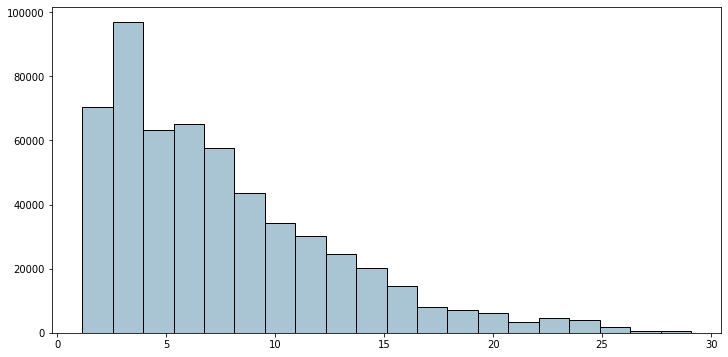

In [32]:
plt.figure(figsize=(12,6))
fig, axs = plt.subplots(ncols=1, figsize=(12, 6))
_ = axs.hist(df_bat_data.z, bins=20, color='#A9C5D3', edgecolor='black')

In [33]:
df_bat_data.z.skew()

1.1921940875433643

In [34]:
np.log(df_bat_data.z).skew()

-0.051505284926220966

In [35]:
df_pixel_coord_bat_data = pd.DataFrame()

px = list()
py = list()
zlist = list()
    
for i, row in enumerate(df_bat_data.itertuples()):
    x = row[1]
    y = row[2]
    z = row[3]
    pixel = ((x-start_value_x)/float(scale_x), (y-start_value_y)/float(scale_y)) 
    px.append(pixel[0])
    py.append(pixel[1])
    zlist.append(z)

df_pixel_coord_bat_data['x'] = px
df_pixel_coord_bat_data['y'] = py
df_pixel_coord_bat_data['z'] = zlist

In [36]:
df_pixel_coord_bat_data = df_pixel_coord_bat_data[df_pixel_coord_bat_data.y > 0 ]
df_pixel_coord_bat_data

,x,y,z
0,236.782,1016.283,1.96
1,236.795,1016.285,1.98
2,236.807,1016.288,1.98
3,236.819,1016.291,1.97
4,236.831,1016.293,1.98
...,...,...,...
533307,618.304,0.091,7.93
533308,618.339,0.070,7.93
533309,618.375,0.049,7.93
533310,618.412,0.029,7.93


In [37]:
jb.dump(df_pixel_coord_bat_data,'../data/generated/df_newimages_bat_downside.pkl.z')

['../data/generated/df_newimages_bat_downside.pkl.z']

In [39]:
df_pixel_coord_bat_data['x'] = df_pixel_coord_bat_data['x'].apply(lambda x: int(x))
df_pixel_coord_bat_data['y'] = df_pixel_coord_bat_data['y'].apply(lambda x: int(x))

In [40]:
df_variance = df_pixel_coord_bat_data.groupby(['x', 'y']).var().reset_index()
df_variance = df_variance[df_variance.z > 0.05]
df_variance

,x,y,z
101,235,1034,0.096245
109,235,1042,0.098823
110,235,1043,0.089653
326,303,1017,0.144762
535,407,996,0.260884
...,...,...,...
18641,2019,67,1.527670
18993,2106,17,1.712316
19069,2123,48,0.071184
19072,2124,49,0.187306


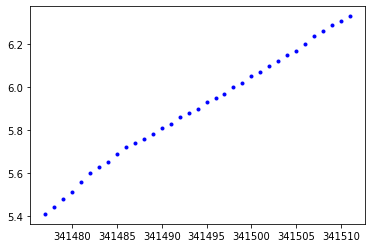

In [41]:
df_testing = df_pixel_coord_bat_data[(df_pixel_coord_bat_data.x==2123)&(df_pixel_coord_bat_data.y==48)]
plt.plot(df_testing.index,df_testing['z'],'b.')

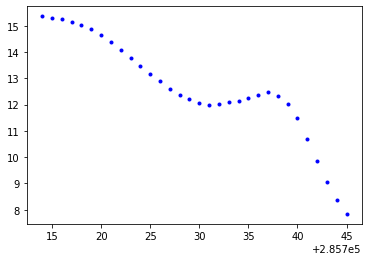

In [42]:
df_testing = df_pixel_coord_bat_data[(df_pixel_coord_bat_data.x==1805)&(df_pixel_coord_bat_data.y==296)]
plt.plot(df_testing.index,df_testing['z'],'b.')

In [69]:
df_pixel_coord_bat_data_mean = df_pixel_coord_bat_data.groupby(['x', 'y']).mean()
df_pixel_coord_bat_data_mean.reset_index(inplace=True)
df_pixel_coord_bat_data_mean

,x,y,z
0,233,1130,3.195862
1,233,1131,3.273030
2,233,1132,3.299687
3,233,1133,3.268182
4,233,1134,3.278125
...,...,...,...
19282,2293,86,2.264000
19283,2294,86,1.909714
19284,2295,86,1.539000
19285,2295,87,1.360263


In [71]:
df_pixel_coord_bat_data_mean = df_pixel_coord_bat_data_mean[~df_pixel_coord_bat_data_mean.index.isin(df_variance.index)]
df_pixel_coord_bat_data_mean.describe()

,x,y,z
count,18255.000000,18255.000000,18255.000000
mean,1131.875103,654.111257,7.128341
std,470.496860,409.007310,4.516452
min,233.000000,1.000000,1.164255
25%,774.000000,335.000000,3.452116
50%,1017.000000,613.000000,6.155000
75%,1508.000000,949.000000,9.679444
max,2296.000000,1638.000000,25.792759


In [72]:
for k, v in bands_arrays_dict.items():
    aux = list()
    for i, row in enumerate(df_pixel_coord_bat_data_mean.itertuples()):
        px = row[1]
        py = row[2]
        aux.append(v[py][px])
    df_pixel_coord_bat_data_mean[k] = aux

In [73]:
df_pixel_coord_bat_data_mean.head(2)

,x,y,z,b1,b2,b3,b4,b5,b6,b7,b8
0,233,1130,3.195862,0.1199,0.0866,0.0667,0.0464,0.049,0.0316,0.0283,0.0238
1,233,1131,3.273030,0.1199,0.0880,0.0668,0.0457,0.049,0.0316,0.0283,0.0237


In [74]:
df = df_pixel_coord_bat_data_mean.copy()

In [75]:
df['b2b4'] = df[['b2', 'b4']].apply(lambda x: pixel_log_ratio(x.b2, x.b4), axis=1)
df['b3b4'] = df[['b3', 'b4']].apply(lambda x: pixel_log_ratio(x.b3, x.b4), axis=1)
df['ndwi15'] = df[['b1', 'b5']].apply(lambda x: pixel_ndwi(x.b1, x.b5), axis=1)
df['ndwi24'] = df[['b2', 'b4']].apply(lambda x: pixel_ndwi(x.b2, x.b4), axis=1)
df['ndwi53'] = df[['b5', 'b3']].apply(lambda x: pixel_ndwi(x.b5, x.b3), axis=1)
df['cspmb7'] = 2950*pow(df['b7'],1.357)
df.head()

,x,y,z,b1,b2,b3,b4,b5,b6,b7,b8,b2b4,b3b4,ndwi15,ndwi24,ndwi53,cspmb7
0,233,1130,3.195862,0.1199,0.0866,0.0667,0.0464,0.0490,0.0316,0.0283,0.0238,1.162614,1.094573,0.419775,0.302256,-0.152982,23.382784
1,233,1131,3.273030,0.1199,0.0880,0.0668,0.0457,0.0490,0.0316,0.0283,0.0237,1.171434,1.099318,0.419775,0.316380,-0.153713,23.382784
2,233,1132,3.299687,0.1199,0.0879,0.0666,0.0461,0.0488,0.0324,0.0281,0.0238,1.168473,1.096035,0.421458,0.311940,-0.154246,23.158824
3,233,1133,3.268182,0.1199,0.0882,0.0692,0.0452,0.0488,0.0324,0.0281,0.0232,1.175411,1.111754,0.421458,0.322339,-0.172881,23.158824
4,233,1134,3.278125,0.1196,0.0884,0.0677,0.0454,0.0489,0.0323,0.0285,0.0238,1.174645,1.104724,0.419585,0.321375,-0.161235,23.607309


In [76]:
jb.dump(df, '../data/generated/df_newimages_bands_downside_low_var_filter.pkl.z')

['../data/generated/df_newimages_bands_downside_low_var_filter.pkl.z']

In [45]:
bgr_image = np.dstack((bands_arrays_dict['b2'],bands_arrays_dict['b3'],bands_arrays_dict['b4']))
bgr_image = bgr_image.clip(0,1)
bgr_image = (bgr_image*255.99).astype(np.uint8)
cv2.imwrite('../data/generated/rgb_image.jpg', bgr_image)

True